# Chapter 4: Questions 14 (page 197 - 198)

In [1]:
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec
from ISLP.models import sklearn_selected
from sklearn.linear_model import LinearRegression

# Load data
local_path = '/Users/anhnguyen/Documents/GitHub/2025AAE722_AnhNguyen/2025 AAE722 Anh Nguyen Submission/ALL CSV FILES - 2nd Edition/Auto.csv'
auto = pd.read_csv(local_path)

# Keep a clean copy; drop the non-predictor "name", drop NA
auto = auto.drop(columns=['name'], errors='ignore').dropna()


### (a) Create binary variable mpg01

In [2]:
# create binary mpg01: 1 if mpg > median, 0 otherwise
mpg_median = auto['mpg'].median()
auto['mpg01'] = (auto['mpg'] > mpg_median).astype(int)

# display median, distribution, and first rows to verify
print(f"mpg median = {mpg_median}")
print(auto['mpg01'].value_counts())
print(auto[['mpg', 'mpg01']].head())

mpg median = 23.0
mpg01
0    206
1    191
Name: count, dtype: int64
    mpg  mpg01
0  18.0      0
1  15.0      0
2  18.0      0
3  16.0      0
4  17.0      0


### (b) Explore data graphically

Group means by mpg01:
mpg01                   0            1
mpg             17.188780    30.305348
displacement   268.004878   113.735294
horsepower     128.307317    78.336898
weight        3581.780488  2315.229947
acceleration    14.691220    16.473262


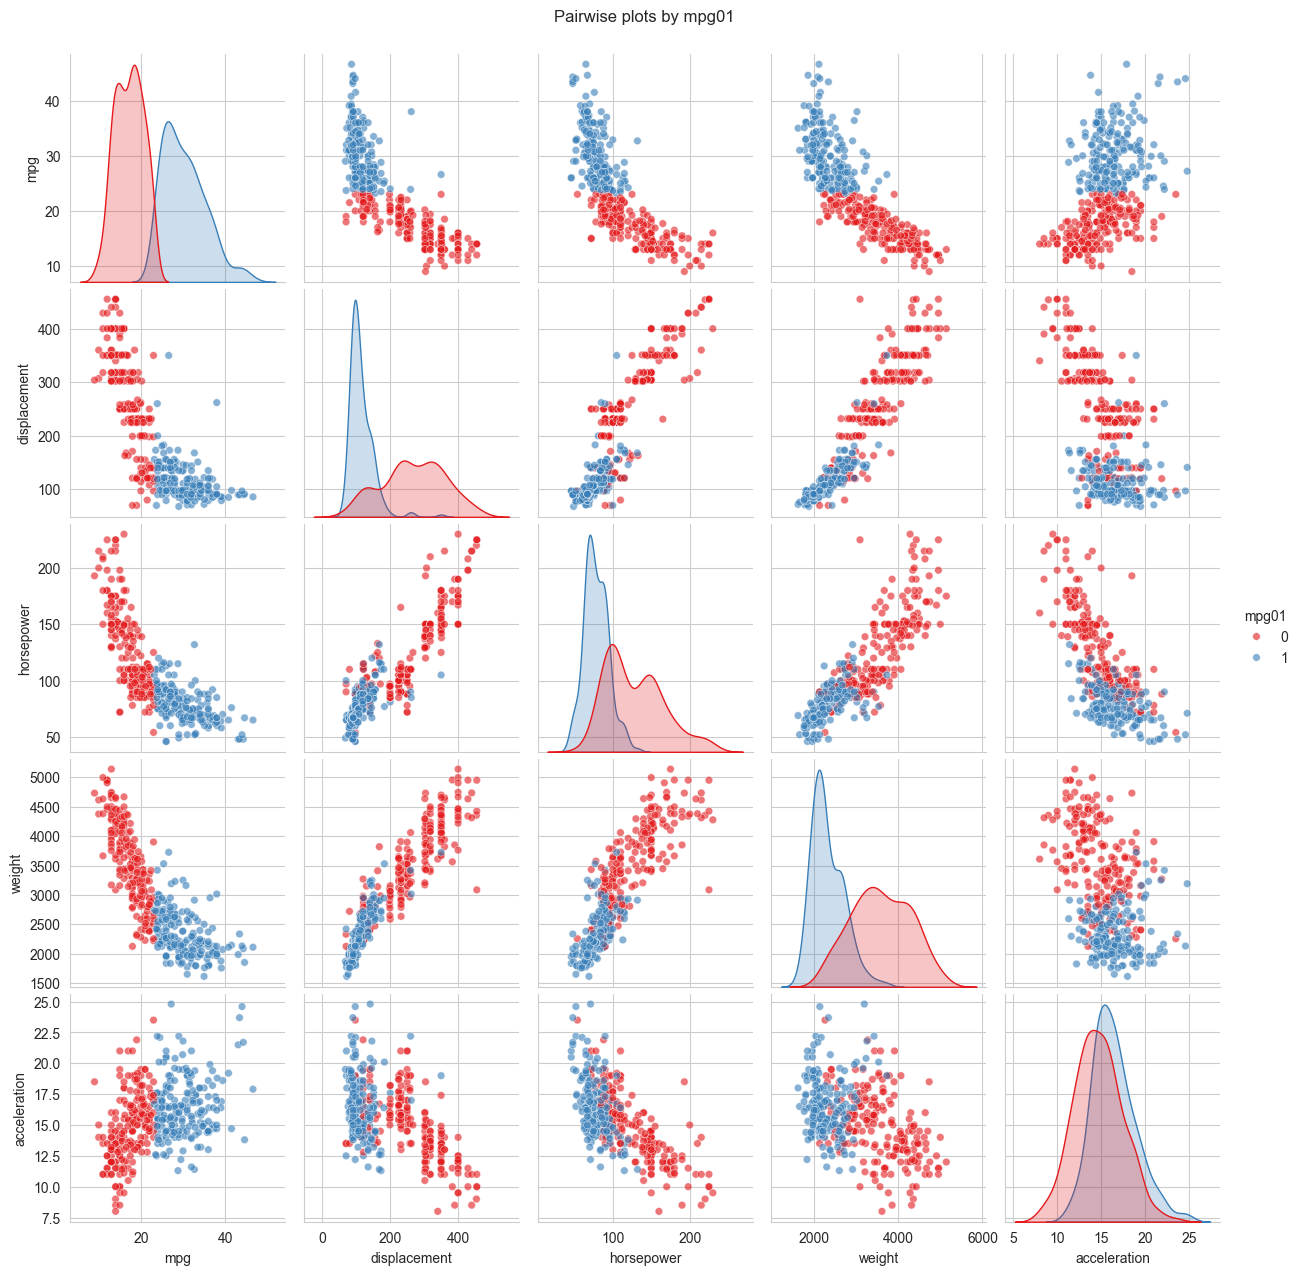

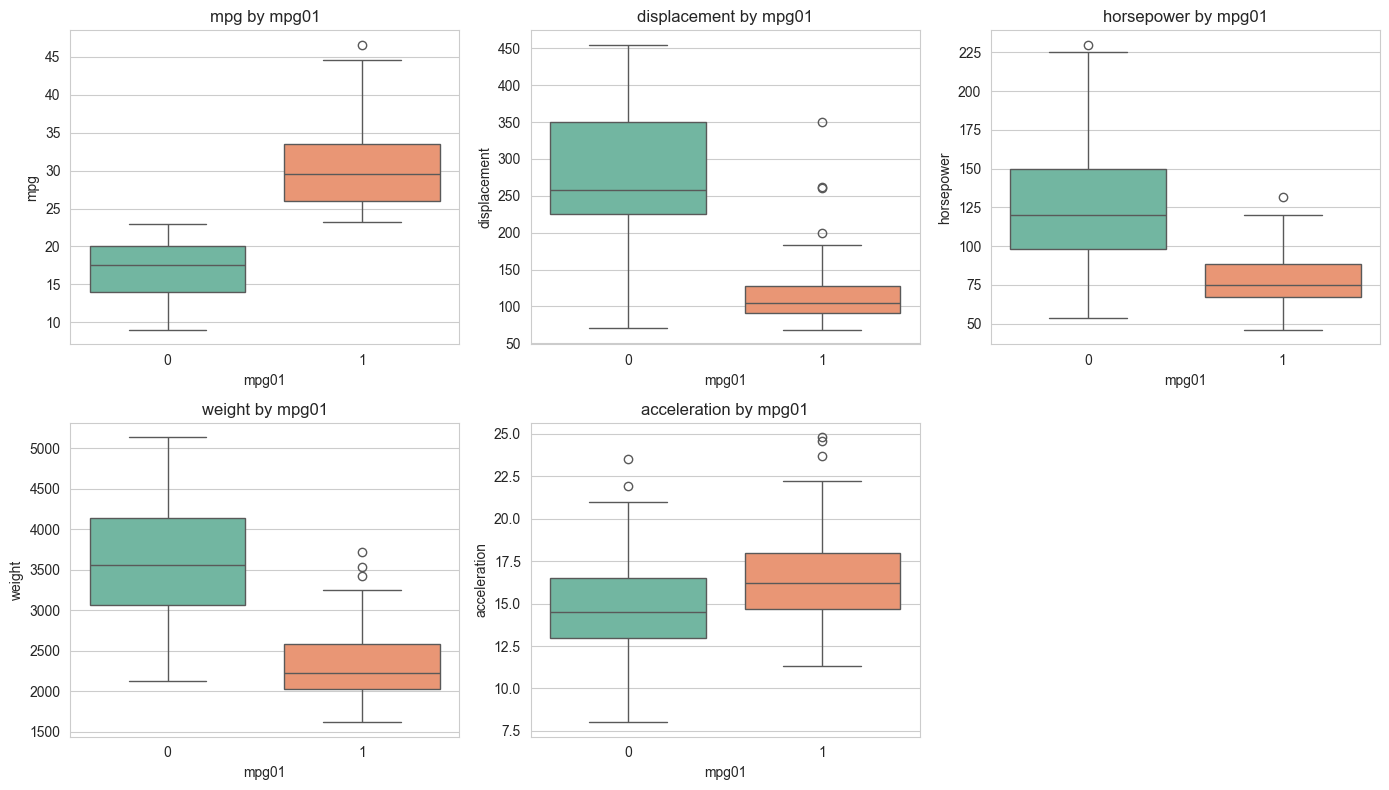

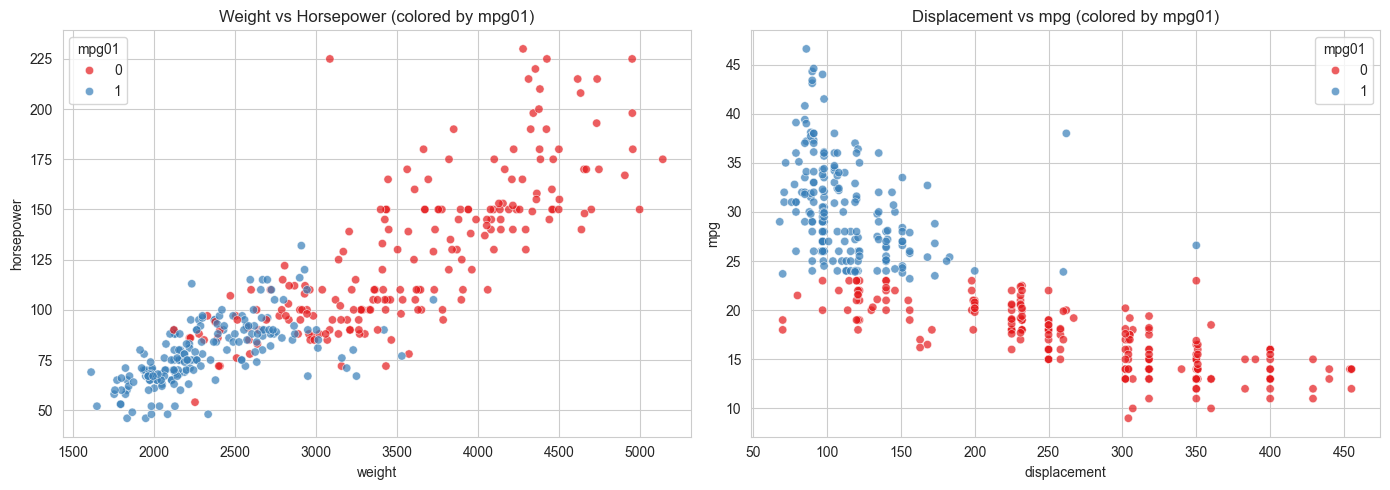

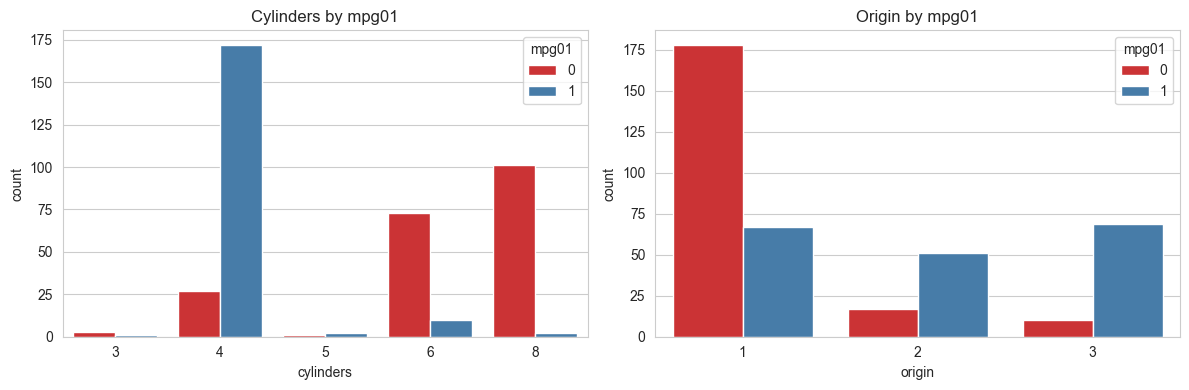

In [3]:
#ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

import matplotlib.pyplot as plt

# Prepare a plotting-friendly copy (convert horsepower to numeric if needed)
adata = auto.copy()
adata['horsepower'] = pd.to_numeric(adata['horsepower'], errors='coerce')
adata = adata.dropna(subset=['horsepower']).reset_index(drop=True)

# Numeric features to inspect (exclude mpg01 itself)
num_cols = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']

# 1) Pairwise relationships colored by mpg01
sns.set_style('whitegrid')
g = sns.pairplot(adata, vars=num_cols, hue='mpg01', palette='Set1',
                 diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30})
g.fig.suptitle("Pairwise plots by mpg01", y=1.02)

# 2) Boxplots of each numeric feature by mpg01
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(x='mpg01', y=col, data=adata, ax=axes[i], palette='Set2')
    axes[i].set_title(f"{col} by mpg01")
axes[-1].axis('off')
plt.tight_layout()

# 3) Scatter examples highlighting separation (weight vs horsepower, displacement vs mpg)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x='weight', y='horsepower', hue='mpg01', data=adata,
                palette='Set1', alpha=0.7, ax=ax[0])
ax[0].set_title('Weight vs Horsepower (colored by mpg01)')
sns.scatterplot(x='displacement', y='mpg', hue='mpg01', data=adata,
                palette='Set1', alpha=0.7, ax=ax[1])
ax[1].set_title('Displacement vs mpg (colored by mpg01)')
plt.tight_layout()

# 4) Categorical summaries: cylinders and origin distribution by mpg01
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x='cylinders', hue='mpg01', data=adata, palette='Set1', ax=ax[0])
ax[0].set_title('Cylinders by mpg01')
sns.countplot(x='origin', hue='mpg01', data=adata, palette='Set1', ax=ax[1])
ax[1].set_title('Origin by mpg01')
plt.tight_layout()

# 5) Print group means to summarize numeric differences
print("Group means by mpg01:")
print(adata.groupby('mpg01')[num_cols].mean().T)

In [4]:
# Summarize findings from the exploratory analysis (uses existing variables: adata, num_cols)
# This cell prints concise, data-driven findings.

# Class balance
counts = adata['mpg01'].value_counts().sort_index()
total = len(adata)
pct0 = counts.get(0, 0) / total * 100
pct1 = counts.get(1, 0) / total * 100

# Group means for numeric features
group_means = adata.groupby('mpg01')[num_cols].mean()

# Correlations with mpg
corr_with_mpg = adata[num_cols].corr()['mpg'].drop('mpg').sort_values(ascending=False)

# Effect sizes (Cohen's d) between mpg01 groups for numeric features
effect_sizes = {}
for col in num_cols:
    g0 = adata.loc[adata['mpg01'] == 0, col]
    g1 = adata.loc[adata['mpg01'] == 1, col]
    n0, n1 = len(g0), len(g1)
    m0, m1 = g0.mean(), g1.mean()
    s0, s1 = g0.std(ddof=1), g1.std(ddof=1)
    pooled_sd = (( (n0-1)*s0**2 + (n1-1)*s1**2 ) / (n0 + n1 - 2))**0.5 if n0 + n1 > 2 else np.nan
    d = (m1 - m0) / pooled_sd if pooled_sd > 0 else np.nan
    effect_sizes[col] = d

# Rank features by absolute effect size
es_series = pd.Series(effect_sizes).abs().sort_values(ascending=False)

# Print concise findings
print("Findings:")
print(f"- Class balance: mpg01=0: {counts.get(0,0)} ({pct0:.1f}%), mpg01=1: {counts.get(1,0)} ({pct1:.1f}%).")
print("\n- Group means (mpg01=0 vs mpg01=1):")
print(group_means.T.round(2))

print("\n- Correlation with mpg (desc):")
for feat, val in corr_with_mpg.items():
    print(f"  {feat}: {val:.3f}")

print("\n- Features ranked by separation (Cohen's d, absolute):")
for feat, val in es_series.items():
    d = effect_sizes[feat]
    sign = "+" if d > 0 else "-"
    print(f"  {feat}: d = {d:.3f} (abs={abs(d):.3f})")

# Short interpreted summary
top = es_series.index[0]
print(f"\nInterpretation summary:")
print(f"- Higher mpg (mpg01=1) is associated with lower {', '.join([f for f in es_series.index if effect_sizes[f] < 0][:3])}" 
      f" and higher {', '.join([f for f in es_series.index if effect_sizes[f] > 0][:3])} (see ranked effect sizes).")
print(f"- The single strongest separating feature is '{top}' by absolute Cohen's d.")

Findings:
- Class balance: mpg01=0: 205 (52.3%), mpg01=1: 187 (47.7%).

- Group means (mpg01=0 vs mpg01=1):
mpg01               0        1
mpg             17.19    30.31
displacement   268.00   113.74
horsepower     128.31    78.34
weight        3581.78  2315.23
acceleration    14.69    16.47

- Correlation with mpg (desc):
  acceleration: 0.423
  horsepower: -0.778
  displacement: -0.805
  weight: -0.832

- Features ranked by separation (Cohen's d, absolute):
  mpg: d = 3.097 (abs=3.097)
  weight: d = -2.235 (abs=2.235)
  displacement: d = -2.179 (abs=2.179)
  horsepower: d = -1.705 (abs=1.705)
  acceleration: d = 0.682 (abs=0.682)

Interpretation summary:
- Higher mpg (mpg01=1) is associated with lower weight, displacement, horsepower and higher mpg, acceleration (see ranked effect sizes).
- The single strongest separating feature is 'mpg' by absolute Cohen's d.


### (d) Split the data into a training set and a test set

In [5]:
from sklearn.model_selection import train_test_split

# predictors: exclude the original mpg (leak) and the target mpg01
X = adata.drop(columns=['mpg', 'mpg01'])
y = adata['mpg01']

# stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train counts:\n{y_train.value_counts()}\ny_test counts:\n{y_test.value_counts()}")

X_train: (274, 7), X_test: (118, 7)
y_train counts:
mpg01
0    143
1    131
Name: count, dtype: int64
y_test counts:
mpg01
0    62
1    56
Name: count, dtype: int64


### (d) LDA 

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix

# choose the top predictors associated with mpg01 (excluding mpg)
features = ['weight', 'displacement', 'horsepower']

lda = LinearDiscriminantAnalysis()
lda.fit(X_train[features], y_train)

y_pred = lda.predict(X_test[features])

acc = accuracy_score(y_test, y_pred)
test_error = 1 - acc

print("Features used:", features)
print("Test accuracy:", round(acc, 4))
print("Test error (misclassification rate):", round(test_error, 4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Features used: ['weight', 'displacement', 'horsepower']
Test accuracy: 0.8729
Test error (misclassification rate): 0.1271

Confusion matrix:
 [[50 12]
 [ 3 53]]


### (e) QDA

In [7]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix

# use the same top features as with LDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train[features], y_train)

y_qda_pred = qda.predict(X_test[features])

acc_qda = accuracy_score(y_test, y_qda_pred)
test_error_qda = 1 - acc_qda

print("Features used:", features)
print("QDA test accuracy:", round(acc_qda, 4))
print("QDA test error (misclassification rate):", round(test_error_qda, 4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_qda_pred))

Features used: ['weight', 'displacement', 'horsepower']
QDA test accuracy: 0.8983
QDA test error (misclassification rate): 0.1017

Confusion matrix:
 [[53  9]
 [ 3 53]]


### (f) Logistic regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

features = ['weight', 'displacement', 'horsepower']

logreg = LogisticRegression(solver='liblinear', random_state=42)
logreg.fit(X_train[features], y_train)

y_log_pred = logreg.predict(X_test[features])

acc_log = accuracy_score(y_test, y_log_pred)
test_error_log = 1 - acc_log

print("Features used:", features)
print("Logistic Regression test accuracy:", round(acc_log, 4))
print("Logistic Regression test error (misclassification rate):", round(test_error_log, 4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_log_pred))

Features used: ['weight', 'displacement', 'horsepower']
Logistic Regression test accuracy: 0.8644
Logistic Regression test error (misclassification rate): 0.1356

Confusion matrix:
 [[50 12]
 [ 4 52]]


### (g) Naive Bayes

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

# use the same top features identified earlier
nb = GaussianNB()
nb.fit(X_train[features], y_train)

y_nb_pred = nb.predict(X_test[features])

acc_nb = accuracy_score(y_test, y_nb_pred)
test_error_nb = 1 - acc_nb

print("Features used:", features)
print("Naive Bayes test accuracy:", round(acc_nb, 4))
print("Naive Bayes test error (misclassification rate):", round(test_error_nb, 4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_nb_pred))

Features used: ['weight', 'displacement', 'horsepower']
Naive Bayes test accuracy: 0.8644
Naive Bayes test error (misclassification rate): 0.1356

Confusion matrix:
 [[50 12]
 [ 4 52]]


### (h) KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# use the selected features already defined in the notebook
X_train_feat = X_train[features]
X_test_feat = X_test[features]

# scale features (fit on train, apply to test)
scaler = StandardScaler().fit(X_train_feat)
X_train_s = scaler.transform(X_train_feat)
X_test_s = scaler.transform(X_test_feat)

ks = [1, 3, 5, 7, 9, 11, 15, 21]
results = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_s, y_train)
    y_knn = knn.predict(X_test_s)
    acc_k = accuracy_score(y_test, y_knn)
    test_err_k = 1 - acc_k
    results.append((k, acc_k, test_err_k))
    print(f"K={k:2d}  accuracy={acc_k:.4f}  test_error={test_err_k:.4f}")

# report best k (highest accuracy / lowest test error)
best_k, best_acc, best_err = max(results, key=lambda t: t[1])
print("\nBest K:", best_k, "with accuracy =", round(best_acc, 4), "and test error =", round(best_err, 4))

K= 1  accuracy=0.8729  test_error=0.1271
K= 3  accuracy=0.8898  test_error=0.1102
K= 5  accuracy=0.9068  test_error=0.0932
K= 7  accuracy=0.9153  test_error=0.0847
K= 9  accuracy=0.9068  test_error=0.0932
K=11  accuracy=0.9068  test_error=0.0932
K=15  accuracy=0.8898  test_error=0.1102
K=21  accuracy=0.8814  test_error=0.1186

Best K: 7 with accuracy = 0.9153 and test error = 0.0847


# Chapter 5: Question 8 (page 227)

### (a) Generate a simulated data set

In [11]:
# simulate data (numpy already imported in the notebook)
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

n = x.shape[0]
p = 1  # one original predictor (x). If you treat x^2 as an additional feature, p = 2.

print(f"n = {n}")
print(f"p = {p}  # (or p = 2 if you count x^2 as a separate predictor)")

# Data-generating model (indexing observations by i):
# y_i = x_i - 2 x_i^2 + ε_i,    ε_i ~ N(0, 1) (independent noise)
print("\nModel (per observation): y_i = x_i - 2 * x_i**2 + ε_i,   ε_i ~ N(0,1)")

n = 100
p = 1  # (or p = 2 if you count x^2 as a separate predictor)

Model (per observation): y_i = x_i - 2 * x_i**2 + ε_i,   ε_i ~ N(0,1)


### (b) Scatterplot

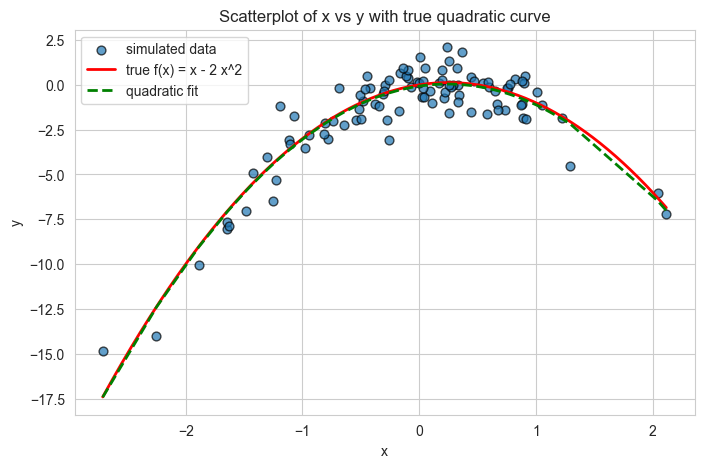

Linear model:  R^2 = 0.318, RMSE = 2.434
Quadratic model: R^2 = 0.887, RMSE = 0.992

Comment: The scatter shows a clear nonlinear (quadratic) relationship. The quadratic fit closely follows the true curve and achieves much better R^2 / lower RMSE than the linear model, confirming the data-generating process is nonlinear (y ≈ x - 2 x^2) with added noise.


In [12]:
from math import sqrt

# scatterplot of x vs y with the true curve and simple model comparisons
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x, y, alpha=0.7, s=40, edgecolor='k', label='simulated data')

# true noiseless function
xs = np.linspace(x.min(), x.max(), 300)
ax.plot(xs, xs - 2 * xs**2, color='red', lw=2, label='true f(x) = x - 2 x^2')

# fit a linear model and a quadratic model to quantify fit
lr = LinearRegression().fit(x.reshape(-1, 1), y)
y_lin = lr.predict(x.reshape(-1, 1))

lr2 = LinearRegression().fit(np.column_stack([x, x**2]), y)
y_quad = lr2.predict(np.column_stack([x, x**2]))

# plot quadratic fit (sorted for a clean line)
idx = np.argsort(x)
ax.plot(x[idx], y_quad[idx], color='green', lw=2, linestyle='--', label='quadratic fit')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Scatterplot of x vs y with true quadratic curve')
ax.legend()
plt.show()

# Quantitative comparison
rmse_lin = sqrt(np.mean((y - y_lin) ** 2))
rmse_quad = sqrt(np.mean((y - y_quad) ** 2))
r2_lin = lr.score(x.reshape(-1, 1), y)
r2_quad = lr2.score(np.column_stack([x, x**2]), y)

print(f"Linear model:  R^2 = {r2_lin:.3f}, RMSE = {rmse_lin:.3f}")
print(f"Quadratic model: R^2 = {r2_quad:.3f}, RMSE = {rmse_quad:.3f}")

# Short comment
print("\nComment: The scatter shows a clear nonlinear (quadratic) relationship. "
    "The quadratic fit closely follows the true curve and achieves much better "
    "R^2 / lower RMSE than the linear model, confirming the data-generating "
    "process is nonlinear (y ≈ x - 2 x^2) with added noise.")

### (c) set a random seed and then compute the LOOCV errors

In [13]:
# Set seed and compute LOOCV errors for polynomial models degree 1..4
np.random.seed(1)  # reproducibility (LOOCV is deterministic here)

def poly_features(x_arr, deg):
    # return columns x, x^2, ..., x^deg (LinearRegression will add intercept)
    return np.column_stack([x_arr**j for j in range(1, deg+1)])

n = x.shape[0]
loocv_results = {}

for deg in range(1, 5):
    sqerrs = []
    for i in range(n):
        # train on all except i
        X_train = poly_features(np.delete(x, i), deg)
        y_train = np.delete(y, i)
        X_val = poly_features(x[i:i+1], deg)

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)[0]
        sqerrs.append((y[i] - y_pred) ** 2)

    mse = np.mean(sqerrs)
    rmse = np.sqrt(mse)
    loocv_results[deg] = {'LOOCV_MSE': mse, 'LOOCV_RMSE': rmse}

# Print concise summary
for deg, res in loocv_results.items():
    print(f"Degree {deg}: LOOCV MSE = {res['LOOCV_MSE']:.4f}, LOOCV RMSE = {res['LOOCV_RMSE']:.4f}")

Degree 1: LOOCV MSE = 6.6330, LOOCV RMSE = 2.5755
Degree 2: LOOCV MSE = 1.1229, LOOCV RMSE = 1.0597
Degree 3: LOOCV MSE = 1.3018, LOOCV RMSE = 1.1410
Degree 4: LOOCV MSE = 1.3324, LOOCV RMSE = 1.1543


### (d) Repeat (c) but using another random seed

In [14]:
# Repeat (c) with a different random seed and compare results
np.random.seed(2)  # different seed (should not affect LOOCV here)

loocv_results_seed2 = {}
n = x.shape[0]

for deg in range(1, 5):
    sqerrs = []
    for i in range(n):
        X_train = poly_features(np.delete(x, i), deg)
        y_train = np.delete(y, i)
        X_val = poly_features(x[i:i+1], deg)

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)[0]
        sqerrs.append((y[i] - y_pred) ** 2)

    mse = np.mean(sqerrs)
    rmse = np.sqrt(mse)
    loocv_results_seed2[deg] = {'LOOCV_MSE': mse, 'LOOCV_RMSE': rmse}


print("\nLOOCV results (new seed 2):")
for deg, res in loocv_results_seed2.items():
    print(f" Degree {deg}: MSE={res['LOOCV_MSE']:.6f}, RMSE={res['LOOCV_RMSE']:.6f}")

# Check equality
all_same = True
for deg in range(1, 5):
    a = loocv_results[deg]['LOOCV_MSE']
    b = loocv_results_seed2[deg]['LOOCV_MSE']
    if not np.isclose(a, b):
        all_same = False
        print(f"\nDifference found for degree {deg}: original MSE={a}, new MSE={b}")

print("\nAre the results the same for all degrees?", all_same)

# Short explanation:
print("\nExplanation: LOOCV here is deterministic given the fixed dataset (x, y) "
      "and LinearRegression (closed-form) has no randomness. Changing the global "
      "random seed does not alter x and y (they were already generated) nor the "
      "LOOCV procedure, so the LOOCV errors remain the same.")


LOOCV results (new seed 2):
 Degree 1: MSE=6.633030, RMSE=2.575467
 Degree 2: MSE=1.122937, RMSE=1.059687
 Degree 3: MSE=1.301797, RMSE=1.140963
 Degree 4: MSE=1.332394, RMSE=1.154294

Are the results the same for all degrees? True

Explanation: LOOCV here is deterministic given the fixed dataset (x, y) and LinearRegression (closed-form) has no randomness. Changing the global random seed does not alter x and y (they were already generated) nor the LOOCV procedure, so the LOOCV errors remain the same.


### (e) Model evaluation


In [15]:
# Identify which polynomial degree had the smallest LOOCV error (uses loocv_results)
best_deg = min(loocv_results, key=lambda d: loocv_results[d]['LOOCV_MSE'])
best_mse = loocv_results[best_deg]['LOOCV_MSE']
best_rmse = loocv_results[best_deg]['LOOCV_RMSE']

print(f"Best degree by LOOCV: {best_deg} (LOOCV MSE = {best_mse:.6f}, LOOCV RMSE = {best_rmse:.6f})")
# Short explanation:
print("Expected? Yes — the data were generated from a quadratic function (y = x - 2 x^2 + noise),")
print("so the degree-2 (quadratic) model having the smallest LOOCV error matches the data-generating process.")

Best degree by LOOCV: 2 (LOOCV MSE = 1.122937, LOOCV RMSE = 1.059687)
Expected? Yes — the data were generated from a quadratic function (y = x - 2 x^2 + noise),
so the degree-2 (quadratic) model having the smallest LOOCV error matches the data-generating process.


### (f) Comment on the statistical significance of the coef estimates

In [30]:
import numpy as np

# Analyze statistical significance of least-squares coefficient estimates (degrees 1..4)
# Assumes x, y, loocv_results, best_deg are already defined in the notebook.

import statsmodels.api as sm

results_inf = {}

for deg in range(1, 5):
    # column names for this design (used for indexing p-values if needed)
    names = ["const"] + [f"x^{j}" for j in range(1, deg+1)]

    # build polynomial design matrix: [1, x, x^2, ..., x^deg]
    X = np.column_stack([x**j for j in range(1, deg+1)])
    X = sm.add_constant(X)
    ols = sm.OLS(y, X).fit()

    # keep concise table of estimates
    coeffs = ols.params
    std_err = ols.bse
    tvals = ols.tvalues
    pvals = ols.pvalues

    # Ensure p-values are a pandas Series with proper index names (pd is available from earlier cells)
    if not isinstance(pvals, pd.Series):
        pvals = pd.Series(np.asarray(pvals), index=names)

    print(f"\nDegree {deg} OLS:")
    print(" term    coef     std_err     t       p")
    for n, c, se, t, p in zip(names, coeffs, std_err, tvals, pvals):
        print(f"{n:6s} {c:9.4f} {se:11.4f} {t:8.3f} {p:8.4g}")

    results_inf[deg] = {"model": ols, "pvalues": pvals}

# Check significance of highest-order term in best model
best_pvals = results_inf[best_deg]['pvalues']
highest_order_term = f"x^{best_deg}"
p_best = best_pvals.get(highest_order_term, None)
if p_best is not None:
    print(f"\nIn the best model (degree {best_deg}), the highest-order term '{highest_order_term}' has p-value = {p_best:.4g}.")
    if p_best < 0.05:
        print("This indicates that the highest-order term is statistically significant at the 5% level.")
    else:
        print("This indicates that the highest-order term is NOT statistically significant at the 5% level.")




Degree 1 OLS:
 term    coef     std_err     t       p
const    -1.4650      0.2468   -5.937 4.41e-08
x^1       1.9494      0.2887    6.752 1.037e-09

Degree 2 OLS:
 term    coef     std_err     t       p
const    -0.0728      0.1191   -0.611   0.5428
x^1       0.9663      0.1264    7.647 1.495e-11
x^2      -2.0047      0.0908  -22.072 1.34e-39

Degree 3 OLS:
 term    coef     std_err     t       p
const    -0.0572      0.1199   -0.477   0.6345
x^1       1.1146      0.1875    5.945 4.449e-08
x^2      -2.0471      0.0990  -20.673 3.969e-37
x^3      -0.0643      0.0601   -1.070   0.2872

Degree 4 OLS:
 term    coef     std_err     t       p
const     0.1008      0.1358    0.743   0.4596
x^1       0.9050      0.2046    4.423 2.591e-05
x^2      -2.5059      0.2211  -11.336 2.396e-19
x^3       0.0338      0.0725    0.466   0.6425
x^4       0.1042      0.0451    2.309  0.02311

In the best model (degree 2), the highest-order term 'x^2' has p-value = 1.34e-39.
This indicates that the highest-

Comment: Yes, these results agree with the conclusions drawn based on the cross-validation results. LOOCV selects degree 2 and OLS finds X^2 significant. 

# Chapter 6: Questions 1 (page 283)

### (a) Which model has the smallest training RSS?

The best subset selection procedure always produces the model with the smallest training RSS for any given number of predictors k. 

This is because in the best subset selection, we fit every possible combination of predictors of size k (all possible k variable models). We then pick the one that minimizes the RSS on the training data. Therefore, we are guaranteed to find the minimum training RSS for that k.

Forward stepwise and backward stepwise only consider a limited path of models rather than all possible subsets, they may miss the true combination of predictors that yields the lowest training RSS. Forward stepwise stars with no predictors and adds one variable at a time, each time choosing the one that gives the greatest immediate improvement in RSS; meamwhile backward stepwise starts with all predictors and removes one at a time, each time dropping the variable that increases RSS the least.


### (b) which model has the smallest test RSS?

There is no guarantee that any of the three methods (best subset, forward stepwise, or backward stepwise) will consistently have the smallest test RSS for a given number of predictors k.

This is because training RSS always decreases (or stays the same) as we add predictors, because we are fitting the training data more closely.
However, test RSS measures how well the model generalizes to unseen data — and can actually increase if we overfit.

The method with the smallest training RSS (best subset) does not necessarily have the smallest test RSS. Because of overfitting, best subset can perform worse on new data, and in practice, any of the three methods could yield the lowest test RSS depending on the dataset.


### (c) True or False

i. True

ii. True

iii. False

iv. False

v. False

# Chapter 6: Question 2 (283 - 284)

### (a) Lasso:


The Lasso, relative to least squares, is (iii) less flexible and hence will give improved prediction accuracy when its increase in bias is less than its decrease in
variance.

This is because the Lasso adds an l2 penalty, shrinking coefficients and (often) setting some to zero. This reduces flexibility (lower effective degrees of freedom), which increases bias but decreases variance. Prediction accuracy on test data improves whenever the reduction in variance outweighs the added bias — i.e., when the total mean squared error decreases.

### (b) Ridge regression:


Ridge regression, relative to least squares, is (iii) less flexible and hence will give improved prediction accuracy when its increase in bias is less than its decrease in
variance.

This is because ridge regression adds an l2 penalty that shrinks coefficients toward zero (no hard zeros). Like the lasso, it constrains model complexity and therefore reduces flexibility relative to OLS. This shrinkage increases bias slightly but substantially reduces variance, leading to better test-set performance when the variance reduction dominates.


### (b) Non-linear methods:


Non-linear methods, relative to least squares, are (ii) more flexible and hence will give improved accuracy when its increase in variance is less than its decrease in bias.

This is because non-linear methods (e.g., polynomial regression, splines, regression trees) can adapt to complex patterns in the data. They are therefore more flexible than linear least squares, typically reducing bias but increasing variance. Test performance improves when the drop in bias (better fit to true relationships) outweighs the increase in variance (overfitting risk).